In [5]:
import sys
sys.path.append('/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/helper_functions')
from load_data import *
from utils import *
from models import *

# Step 1: Read AA (spectra) and AA proportions (ground-truth)

In [6]:
root_dir = '/Users/mahsazarei/Grantlab Brugada Dropbox/TerraMera/Gitlab/Mahsa/AA_APLID/Amino_Acid_manuscript/Data/AA_Data'
file_name_list = ['AA_Data.csv']

In [8]:
df = pd.read_csv(os.path.join(root_dir, file_name_list[0]))
w = [c for c in df.columns if c[0] in np.array(range(10), dtype=str)]
#    df.groupby('vial #')[w].mean().T.plot( legend=False, title=file_name, figsize=(5, 3))


In [9]:
mask_ex = [col.startswith('a') for col in df['vial #']]
names_ex = np.array([col for col in df['vial #'] if col.startswith('a')])
wnums = np.array([float(idx) for idx in w])
specs_ex = df.loc[mask_ex, w].values
w_cm = wavelength_to_wavenumber(wnums, 784.815734863281)
y_names = ['Alanine', 'Asparagine', 'Aspartic Acid', 'Glutamic Acid',
       'Histidine', 'Glucosamine']
y_ex = df.loc[mask_ex, y_names].values

mask_pure = [not col.startswith('a') for col in df['vial #']]
names_pure = np.array([col for col in df['vial #'] if not col.startswith('a')])
specs_pure = df.loc[mask_pure, w].values
print(y_ex.shape, specs_ex.shape, names_ex.shape, specs_pure.shape, names_pure.shape)

(4318, 6) (4318, 1024) (4318,) (60, 1024) (60,)


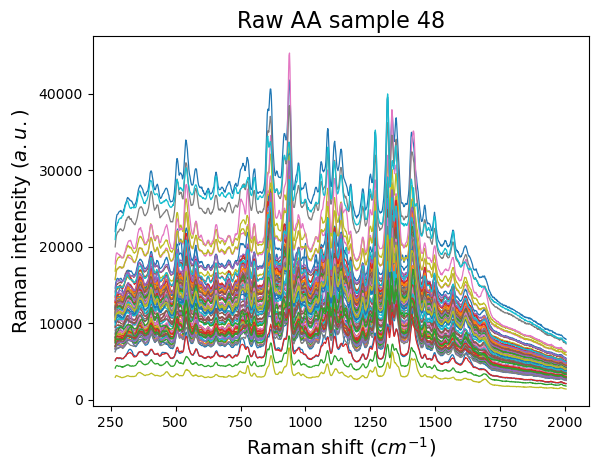

In [10]:
plot_specs(specs_ex[names_ex=='a48'], w_cm,  title='Raw AA sample 48', data='Raman')

# Step 2: Preprocessing Table of Contents
- [1. Background subtraction using Discrete Wavelet Transform (DWT) - one spectrum](#dwt_background)
- [1.1 Background subtraction using Discrete Wavelet Transform (DWT) - all spectra](#dwt_all_spectra)
- [2. SFR calculation](#sfr_calculation)
- [3. SNR calculation](#snr_calculation)
- [4. Z-score normalization](#z_score_normalization)
- [5. (optional) DWT dimensionality reduction](#dimensioanlity_reduction)
- [6. Averaging replicas of each sample](#averaging_replicas)


<a id="dwt_background"></a>
## 1. Background subtraction using Discrete Wavelet Transform (DWT) - one spectrum

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


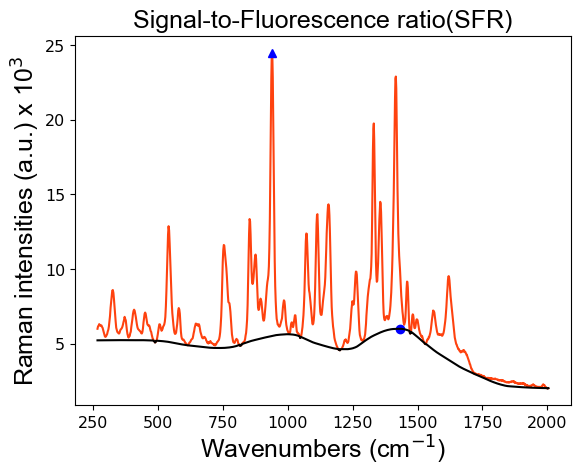

In [11]:
scale = 7           # scale of the DWT multilevel decomposition 
wavelet = 'sym5'    # mother wavelet
iterations = 50    # Bakcground removal iterations
spec = 1000
start = 0
plt.figsize=(15, 5)
tick_label_size = 11.43
name_size = 18
spectrum_bg_removed, bg_approx = dwt_iterative_bg_rm(specs_ex[spec, :][start:], wavelet, scale, iterations)
plt.plot(w_cm[start:], specs_ex[spec, :][start:]/1000, color='#FE420F')
plt.plot(w_cm[np.argmax(specs_ex[spec, :])], np.max(specs_ex[spec])/1000, '^', color='blue', label='Raman Maximum')
plt.plot(w_cm[np.argmax(bg_approx)], np.max(bg_approx)/1000, 'o', color='blue', label='Fluorescence Maximum')
plt.plot(w_cm[start:], bg_approx/1000, color='black')
plt.xlabel('Wavenumbers (cm$^{-1}$)', fontsize=name_size, font='Arial', labelpad=2)
plt.ylabel('Raman intensities (a.u.) x 10$^{3}$', fontsize=name_size, font='Arial', labelpad=2)
plt.title('Signal-to-Fluorescence ratio(SFR)', fontdict={'fontsize': name_size, 'fontname': 'Arial'})
plt.tick_params(axis='both', which='both', labelsize=tick_label_size)


<a id="dwt_all_spectra"></a>
### 1.1 Background subtraction using Discrete Wavelet Transform (DWT) - all spectra

In [12]:
specs_bg_removed = np.zeros(specs_ex.shape)
bg_approx = np.zeros(specs_ex.shape)
for spectrum in range(specs_ex.shape[0]):
    specs_bg_removed[spectrum, :], bg_approx[spectrum, :] = dwt_iterative_bg_rm(specs_ex[spectrum, :], wavelet, scale, iterations)



<a id="sfr_calculation"></a>
## 2. SFR calculation


In [13]:
SFR = []
for i in range(specs_bg_removed.shape[0]):
    SFR.append(np.divide(np.max(specs_bg_removed[i, :]), np.max(bg_approx[i, :])))
SFR_mean = np.mean(np.array(SFR))
SFR_mean

1.3511044591595514

<a id="snr_calculation"></a>
## 3. SNR calculation

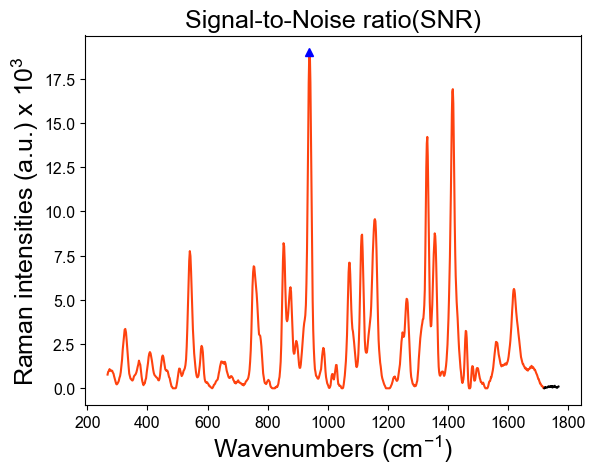

In [14]:
pivot1 = 805
pivot2 = 840
plt.figsize=(15, 5)
plt.plot(w_cm[:pivot1], spectrum_bg_removed[ :pivot1]/1000, color='#FE420F')
plt.plot(w_cm[pivot1:pivot2:], spectrum_bg_removed[pivot1:pivot2:]/1000, color='black', label= 'Noise Region')
plt.plot(w_cm[np.argmax(spectrum_bg_removed)], np.max(spectrum_bg_removed)/1000, '^', color='blue', label= 'Maximum Raman')
plt.xlabel('Wavenumbers (cm$^\mathdefault{-1}$)', fontsize=name_size, font='Arial', labelpad=2)
plt.ylabel('Raman intensities (a.u.) x 10$^\mathdefault{3}$', fontsize=name_size, font='Arial', labelpad=2)
plt.xticks(fontname='Arial') 
plt.yticks(fontname='Arial')
plt.title('Signal-to-Noise ratio(SNR)', fontdict={'fontsize': name_size, 'fontname': 'Arial'})
plt.tick_params(axis='both', which='both', labelsize=tick_label_size) 

In [15]:
specs_norm = np.vstack([norm_mean(s) for s in specs_bg_removed])
SNR = []
for noisy_spec in specs_norm:
    SNR.append(np.divide(np.max(noisy_spec), np.std(noisy_spec[pivot1:pivot2])))
SNR_mean = np.mean(np.array(SNR))
SNR_std = np.std(np.array(SNR))
SNR_mean

232.2129911611851

<a id="z_score_normalization"></a>
## 4. Z-score normalization

In [17]:
specss = np.vstack([norm_mean(s) for s in specs_bg_removed])


<a id="dimensioanlity_reduction"></a>
## 5. (optional) DWT dimensionality reduction 

In [18]:
dwt_dimensionality_reduction = False
#%% (5.1) For just one spectrum (n_features variables instead of 1024 variables)
if dwt_dimensionality_reduction:
    scale = 2           # scale of the DWT multilevel decomposition 
    wavelet = 'sym5'    # mother wavelet

    spectrum_appx_coeffs = pywt.wavedec(specs[spec, :], wavelet, level=scale)[0]
    plt.plot(spectrum_appx_coeffs/1000, color='#FE420F')
    plt.xlabel('Number of features', fontsize=name_size, font='Arial', labelpad=2)
    plt.ylabel('Raman intensities (a.u.) x 10$^\mathdefault{3}$', fontsize=name_size, font='Arial', labelpad=2)
    plt.title('Raman spectrum after dimensioanlity reduction', fontdict={'fontsize': name_size, 'fontname': 'Arial'})
    n_features = spectrum_appx_coeffs.shape[0]
    print(f'Number of features after removing {scale} level of detailed coefficients is {n_features}.')

In [19]:
#%% (5.2) Dimensionality reduction for all spectrum
if dwt_dimensionality_reduction:
    appx_coeffs = np.zeros([specs.shape[0], n_features])
    for spectrum in range(specs.shape[0]):
        appx_coeffs[spectrum, :] = pywt.wavedec(specss[spectrum, :], wavelet, level=scale)[0]
    plt.figure()
    specss = appx_coeffs
    print(specss.shape, y_ex.shape)

<a id="averaging_replicas"></a>
## 6. Averaging replicas of each sample

In [21]:
specss_ave = np.vstack([np.mean(specss[names_ex==name, :], axis=0) for name in np.unique(names_ex)])
y_ave = np.vstack([np.mean(y_ex[names_ex==name, :], axis=0) for name in np.unique(names_ex)])

print(specss_ave.shape, y_ave.shape)

(48, 1024) (48, 6)


# Step 3: Modeling Table of Contents

- 1. [Partial Least Squares Regression (PLSR) optimal number of components - PRESS](#PRESS) 
- 1.1 [Partial Least Squares Regression (PLSR) - Leave-one-out cross validation & K-fold cv](#plsr)
- 2. [Convolutional Neural Network (CNN) - Leave-one-out cross validation](#cnn)
- 3. [PLSR vs CNN calibration figure](#plsrvscnn)

<a id="PRESS"></a>
## 1. Partial Least Squares Regression (PLSR) optimal number of components - PRESS
We achieved convergence at 6 components and thus 6 components should be chosen. Adding more components increases the complexity of the model. While both 6 and 9 components may produce similar R^2 and MSE values, the model with 9 components is inherently more complex. More complex models have a higher risk of overfitting, which means they might perform well on the training data but generalize poorly to new, unseen data.

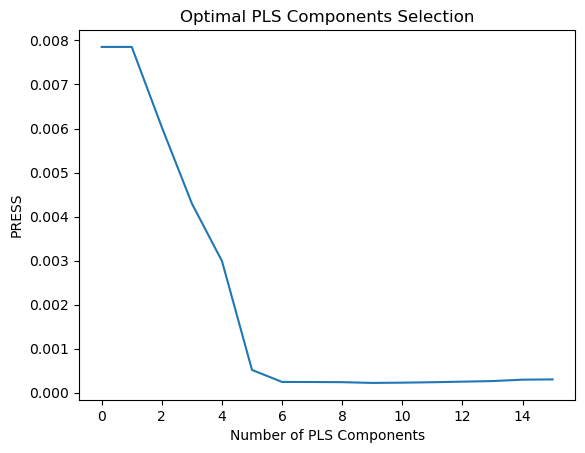

PLSR number of components with minimum MSE: 9


In [22]:
n_components_min_mse = select_optimal_pls_components(specss_ave, y_ave, max_components=15)
print("PLSR number of components with minimum MSE:", n_components_min_mse)

<a id="PRESS"></a>
## 1.1 Partial Least Squares Regression (PLSR) - Leave-one-out cross validation & K-fold cv

In [23]:
y_pred_cv_plsr = cross_val_predict(PLSRegression(n_components=6), specss_ave, y_ave, groups=np.unique(names_ex), cv=LeaveOneOut())
# y_pred_cv_plsr = cross_val_predict(PLSRegression(n_components=15), specss_m4, y_m4, cv=GroupKFold(n_splits=np.unique(names_ex).shape[0]))


r2:0.98, MSE:0.000235, MAE:0.011391
Alanine
r2:0.97, MSE:0.000241, MAE:0.011532
Asparagine
r2:0.96, MSE:0.000352, MAE:0.014673
Aspartic Acid
r2:0.98, MSE:0.000164, MAE:0.009944
Glutamic Acid
r2:0.98, MSE:0.000185, MAE:0.010359
Histidine
r2:0.98, MSE:0.000241, MAE:0.010837
Glucosamine
r2:0.97, MSE:0.000224, MAE:0.011004


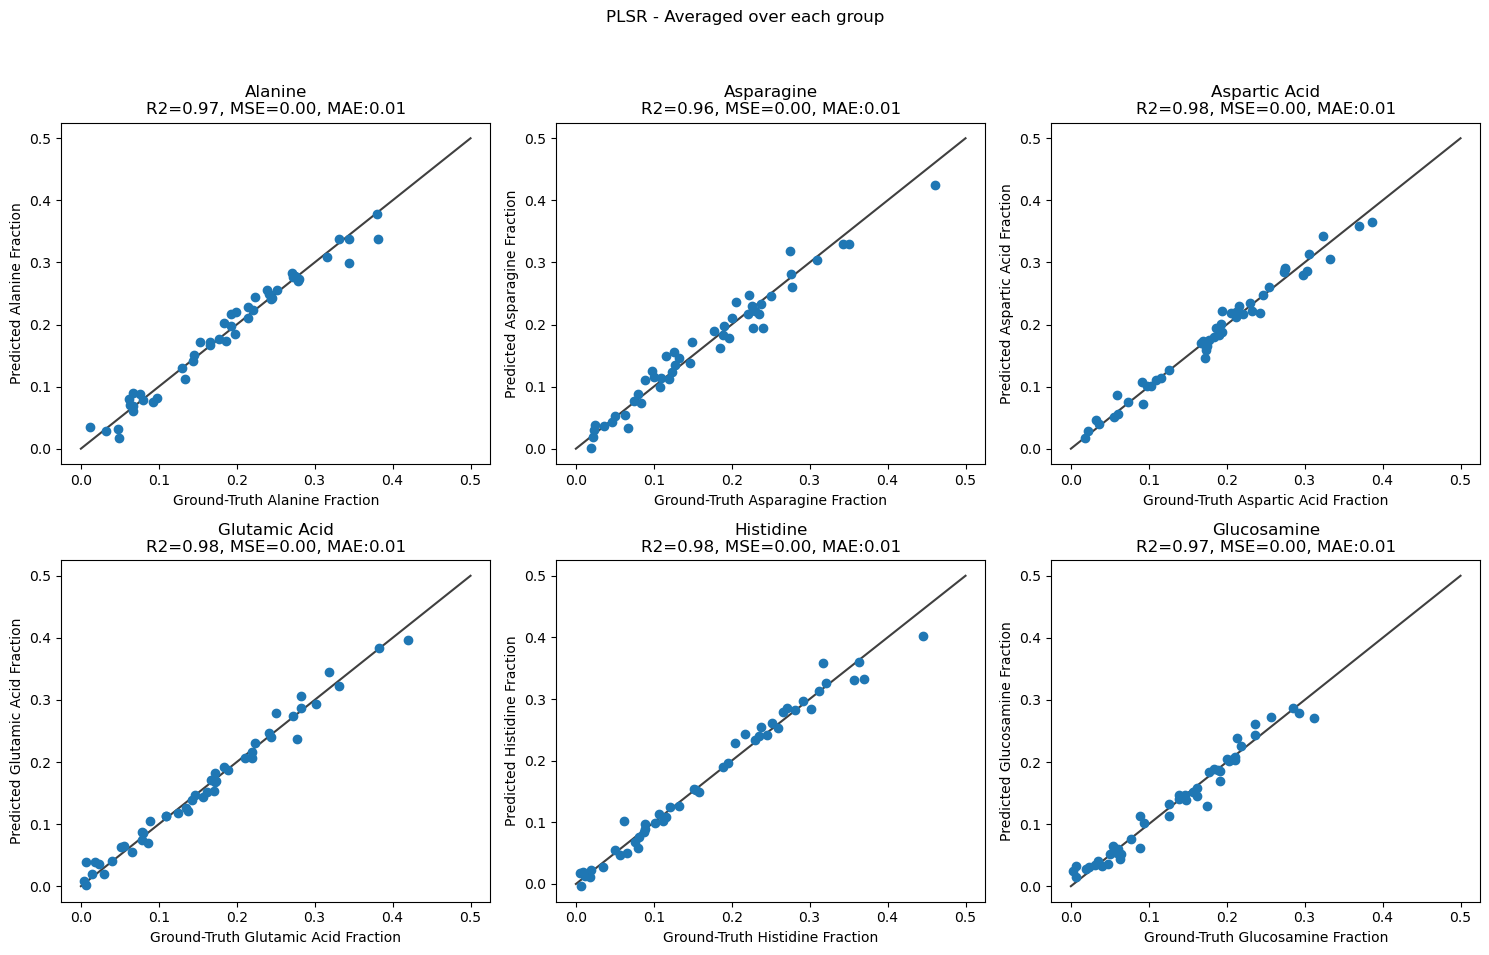

In [24]:
# For PLSR model results
plot_regression_results(y_ave, y_pred_cv_plsr, y_names, model_type='PLSR', title='PLSR Model Results')

<a id="cnn"></a>
## 2. Convolutional Neural Network (CNN) - Leave-one-out cross validation & learning curve

In [25]:
def cnn_AA_general(cfg, input_shape=(1024, 1), num_filters=(16, 32, 64), num_dense_filters=32):
    """
    General model for Raman data.
    Input: Model configurations, input_shape, num_filters, num_dense_filters
    Output: Model
    """
    model = models.Sequential()
    for num_filter in num_filters[:-1]:
        model.add(layers.Conv1D(num_filter, 3, activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(num_filters[-1], 3, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_dense_filters))
    model.add(layers.Dense(6))
    
    model.summary()
    if cfg['compile']:
        model.compile(optimizer=cfg['opt'], loss='mse', metrics=['mse'])
    return model

In [ ]:
# from tensorflow.keras.optimizers import Adam
np.random.seed(42)
model_cfg = {
    'compile': True,
    'opt': Adam(learning_rate=0.001)
}

num_filters = (16, 32, 64) # Specify the number of filters for the convolutional layers
num_dense_filters = 32          # Specify the number of filters in the first dense layer

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

y_pred_cv_cnn_m4 = []
y_cv_cnn_m4 = []

for idx_train, idx_test in LeaveOneOut().split(specss_ave, y_ave, np.unique(names_ex)):
    model = cnn_AA_general(model_cfg, num_filters=num_filters, num_dense_filters=num_dense_filters)
    history = model.fit(np.expand_dims(specss_ave[idx_train, :], 2), y_ave[idx_train], epochs=50, batch_size=32, validation_data=(np.expand_dims(specss_ave[idx_test], 2), y_ave[idx_test]), callbacks=[es])
    y_pred_cv_cnn_m4.append(model.predict(np.expand_dims(specss_ave[idx_test], 2)))
    y_cv_cnn_m4.append(y_ave[idx_test])
    
y_pred_cv_cnn_m4 = np.vstack(y_pred_cv_cnn_m4)
y_cv_cnn_m4 = np.vstack(y_cv_cnn_m4)

# saved_predictios_path = '/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/saved_predictions_CSVs'
# # Save y_pred_cv_cnn_m4 and y_cv_cnn_m4 to CSV
# np.savetxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), y_pred_cv_cnn_m4, delimiter=',')
# np.savetxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), y_cv_cnn_m4, delimiter=',')


Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1022, 16)          64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 511, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 32)           1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 254, 32)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 252, 64)           6208      
                                                                 
 dropout (Dropout)    

Epoch 1/50


2023-08-12 16:52:20.684941: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 [==============================] - 1s 237ms/step - loss: 0.7406 - mse: 0.7406 - val_loss: 0.2070 - val_mse: 0.2070
Epoch 2/50
2/2 [==============================] - 0s 33ms/step - loss: 0.1921 - mse: 0.1921 - val_loss: 0.6761 - val_mse: 0.6761
Epoch 3/50
2/2 [==============================] - 0s 33ms/step - loss: 0.6983 - mse: 0.6983 - val_loss: 0.3603 - val_mse: 0.3603
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3109 - mse: 0.3109 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0555 - mse: 0.0555 - val_loss: 0.1236 - val_mse: 0.1236
Epoch 7/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1089 - mse: 0.1089 - val_loss: 0.1153 - val_mse: 0.1153
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0923 - mse: 0.0923 - val_loss: 0.0

Epoch 1/50
2/2 [==============================] - 1s 194ms/step - loss: 0.5850 - mse: 0.5850 - val_loss: 0.1432 - val_mse: 0.1432
Epoch 2/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1699 - mse: 0.1699 - val_loss: 0.4721 - val_mse: 0.4721
Epoch 3/50
2/2 [==============================] - 0s 29ms/step - loss: 0.5213 - mse: 0.5213 - val_loss: 0.2812 - val_mse: 0.2812
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2739 - mse: 0.2739 - val_loss: 0.0380 - val_mse: 0.0380
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 6/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0221 - mse: 0.0221 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 7/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0589 - val_mse: 0.0589
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0473 - mse: 0.0473 - va

Epoch 1/50
2/2 [==============================] - 1s 189ms/step - loss: 1.1386 - mse: 1.1386 - val_loss: 0.2055 - val_mse: 0.2055
Epoch 2/50
2/2 [==============================] - 0s 29ms/step - loss: 0.3578 - mse: 0.3578 - val_loss: 1.2964 - val_mse: 1.2964
Epoch 3/50
2/2 [==============================] - 0s 34ms/step - loss: 1.2126 - mse: 1.2126 - val_loss: 0.3700 - val_mse: 0.3700
Epoch 4/50
2/2 [==============================] - 0s 31ms/step - loss: 0.3383 - mse: 0.3383 - val_loss: 0.0940 - val_mse: 0.0940
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1250 - mse: 0.1250 - val_loss: 0.2641 - val_mse: 0.2641
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2326 - mse: 0.2326 - val_loss: 0.2738 - val_mse: 0.2738
Epoch 7/50
2/2 [==============================] - 0s 30ms/step - loss: 0.2136 - mse: 0.2136 - val_loss: 0.1715 - val_mse: 0.1715
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1196 - mse: 0.1196 - va

Epoch 1/50
2/2 [==============================] - 1s 198ms/step - loss: 0.4251 - mse: 0.4251 - val_loss: 0.3233 - val_mse: 0.3233
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 0.3515 - mse: 0.3515 - val_loss: 0.2869 - val_mse: 0.2869
Epoch 3/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2589 - mse: 0.2589 - val_loss: 0.1973 - val_mse: 0.1973
Epoch 4/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1763 - mse: 0.1763 - val_loss: 0.1441 - val_mse: 0.1441
Epoch 5/50
2/2 [==============================] - 0s 43ms/step - loss: 0.1252 - mse: 0.1252 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0571 - mse: 0.0571 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0219 - val_mse: 0.0219
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0395 - mse: 0.0395 - va

Epoch 1/50
2/2 [==============================] - 1s 205ms/step - loss: 0.6302 - mse: 0.6302 - val_loss: 0.2114 - val_mse: 0.2114
Epoch 2/50
2/2 [==============================] - 0s 31ms/step - loss: 0.2528 - mse: 0.2528 - val_loss: 0.5591 - val_mse: 0.5591
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.5270 - mse: 0.5270 - val_loss: 0.2785 - val_mse: 0.2785
Epoch 4/50
2/2 [==============================] - 0s 32ms/step - loss: 0.2422 - mse: 0.2422 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 5/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0858 - mse: 0.0858 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 6/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0676 - mse: 0.0676 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 7/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0615 - mse: 0.0615 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0442 - mse: 0.0442 - va

1/1 [==============================] - 0s 61ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 1022, 16)          64        
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 511, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 509, 32)           1568      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 254, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 252, 64)           6208      
                                                                 
 d

Epoch 1/50
2/2 [==============================] - 1s 201ms/step - loss: 0.5519 - mse: 0.5519 - val_loss: 0.1054 - val_mse: 0.1054
Epoch 2/50
2/2 [==============================] - 0s 31ms/step - loss: 0.2274 - mse: 0.2274 - val_loss: 0.4894 - val_mse: 0.4894
Epoch 3/50
2/2 [==============================] - 0s 36ms/step - loss: 0.4658 - mse: 0.4658 - val_loss: 0.1556 - val_mse: 0.1556
Epoch 4/50
2/2 [==============================] - 0s 43ms/step - loss: 0.1431 - mse: 0.1431 - val_loss: 0.0910 - val_mse: 0.0910
Epoch 5/50
2/2 [==============================] - 0s 36ms/step - loss: 0.0830 - mse: 0.0830 - val_loss: 0.0867 - val_mse: 0.0867
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0754 - mse: 0.0754 - val_loss: 0.0572 - val_mse: 0.0572
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0275 - mse: 0.0275 - va

1/1 [==============================] - 0s 64ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 1022, 16)          64        
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 511, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 509, 32)           1568      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 254, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 252, 64)           6208      
                                                                 
 d

Epoch 1/50
2/2 [==============================] - 1s 245ms/step - loss: 0.7158 - mse: 0.7158 - val_loss: 0.2970 - val_mse: 0.2970
Epoch 2/50
2/2 [==============================] - 0s 40ms/step - loss: 0.2966 - mse: 0.2966 - val_loss: 0.6195 - val_mse: 0.6195
Epoch 3/50
2/2 [==============================] - 0s 38ms/step - loss: 0.6603 - mse: 0.6603 - val_loss: 0.4115 - val_mse: 0.4115
Epoch 4/50
2/2 [==============================] - 0s 43ms/step - loss: 0.3326 - mse: 0.3326 - val_loss: 0.1063 - val_mse: 0.1063
Epoch 5/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0678 - mse: 0.0678 - val_loss: 0.0771 - val_mse: 0.0771
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0555 - mse: 0.0555 - val_loss: 0.0938 - val_mse: 0.0938
Epoch 7/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0814 - mse: 0.0814 - val_loss: 0.0840 - val_mse: 0.0840
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0783 - mse: 0.0783 - va

Epoch 1/50
2/2 [==============================] - 1s 226ms/step - loss: 1.2508 - mse: 1.2508 - val_loss: 0.2606 - val_mse: 0.2606
Epoch 2/50
2/2 [==============================] - 0s 39ms/step - loss: 0.3809 - mse: 0.3809 - val_loss: 1.4402 - val_mse: 1.4402
Epoch 3/50
2/2 [==============================] - 0s 31ms/step - loss: 1.3085 - mse: 1.3085 - val_loss: 0.7230 - val_mse: 0.7230
Epoch 4/50
2/2 [==============================] - 0s 37ms/step - loss: 0.5451 - mse: 0.5451 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.1284 - val_mse: 0.1284
Epoch 6/50
2/2 [==============================] - 0s 37ms/step - loss: 0.1356 - mse: 0.1356 - val_loss: 0.2356 - val_mse: 0.2356
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.2225 - mse: 0.2225 - val_loss: 0.1988 - val_mse: 0.1988
Epoch 8/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1790 - mse: 0.1790 - va

Epoch 1/50
2/2 [==============================] - 1s 237ms/step - loss: 0.5405 - mse: 0.5405 - val_loss: 0.1903 - val_mse: 0.1903
Epoch 2/50
2/2 [==============================] - 0s 46ms/step - loss: 0.1784 - mse: 0.1784 - val_loss: 0.4334 - val_mse: 0.4334
Epoch 3/50
2/2 [==============================] - 0s 93ms/step - loss: 0.4841 - mse: 0.4841 - val_loss: 0.2378 - val_mse: 0.2378
Epoch 4/50
2/2 [==============================] - 0s 48ms/step - loss: 0.2299 - mse: 0.2299 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 5/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0591 - val_mse: 0.0591
Epoch 6/50
2/2 [==============================] - 0s 54ms/step - loss: 0.0492 - mse: 0.0492 - val_loss: 0.1233 - val_mse: 0.1233
Epoch 7/50
2/2 [==============================] - 0s 34ms/step - loss: 0.0867 - mse: 0.0867 - val_loss: 0.1116 - val_mse: 0.1116
Epoch 8/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0732 - mse: 0.0732 - va

Epoch 1/50
2/2 [==============================] - 1s 248ms/step - loss: 0.3880 - mse: 0.3880 - val_loss: 0.1985 - val_mse: 0.1985
Epoch 2/50
2/2 [==============================] - 0s 35ms/step - loss: 0.1767 - mse: 0.1767 - val_loss: 0.3976 - val_mse: 0.3976
Epoch 3/50
2/2 [==============================] - 0s 35ms/step - loss: 0.3286 - mse: 0.3286 - val_loss: 0.2299 - val_mse: 0.2299
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1770 - mse: 0.1770 - val_loss: 0.0604 - val_mse: 0.0604
Epoch 5/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 6/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 7/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0264 - mse: 0.0264 - va

Epoch 1/50
2/2 [==============================] - 1s 261ms/step - loss: 0.6358 - mse: 0.6358 - val_loss: 0.1556 - val_mse: 0.1556
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 0.1672 - mse: 0.1672 - val_loss: 0.5826 - val_mse: 0.5826
Epoch 3/50
2/2 [==============================] - 0s 48ms/step - loss: 0.6061 - mse: 0.6061 - val_loss: 0.3207 - val_mse: 0.3207
Epoch 4/50
2/2 [==============================] - 0s 43ms/step - loss: 0.2690 - mse: 0.2690 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 5/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0438 - val_mse: 0.0438
Epoch 6/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0967 - val_mse: 0.0967
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0970 - mse: 0.0970 - val_loss: 0.0818 - val_mse: 0.0818
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0767 - mse: 0.0767 - va

Epoch 1/50
2/2 [==============================] - 1s 271ms/step - loss: 1.5105 - mse: 1.5105 - val_loss: 0.4192 - val_mse: 0.4192
Epoch 2/50
2/2 [==============================] - 0s 46ms/step - loss: 0.5359 - mse: 0.5359 - val_loss: 1.4699 - val_mse: 1.4699
Epoch 3/50
2/2 [==============================] - 0s 39ms/step - loss: 1.2440 - mse: 1.2440 - val_loss: 0.6642 - val_mse: 0.6642
Epoch 4/50
2/2 [==============================] - 0s 38ms/step - loss: 0.4770 - mse: 0.4770 - val_loss: 0.1735 - val_mse: 0.1735
Epoch 5/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1890 - mse: 0.1890 - val_loss: 0.2203 - val_mse: 0.2203
Epoch 6/50
2/2 [==============================] - 0s 33ms/step - loss: 0.2694 - mse: 0.2694 - val_loss: 0.2003 - val_mse: 0.2003
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2286 - mse: 0.2286 - val_loss: 0.1087 - val_mse: 0.1087
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1214 - mse: 0.1214 - va

Epoch 1/50
2/2 [==============================] - 1s 253ms/step - loss: 0.7636 - mse: 0.7636 - val_loss: 0.1163 - val_mse: 0.1163
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 0.2299 - mse: 0.2299 - val_loss: 0.7318 - val_mse: 0.7318
Epoch 3/50
2/2 [==============================] - 0s 48ms/step - loss: 0.7398 - mse: 0.7398 - val_loss: 0.3591 - val_mse: 0.3591
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3233 - mse: 0.3233 - val_loss: 0.0683 - val_mse: 0.0683
Epoch 5/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0871 - val_mse: 0.0871
Epoch 6/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0804 - mse: 0.0804 - val_loss: 0.1208 - val_mse: 0.1208
Epoch 7/50
2/2 [==============================] - 0s 39ms/step - loss: 0.1112 - mse: 0.1112 - val_loss: 0.0969 - val_mse: 0.0969
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0892 - mse: 0.0892 - va

Epoch 1/50
2/2 [==============================] - 1s 243ms/step - loss: 1.1313 - mse: 1.1313 - val_loss: 0.3515 - val_mse: 0.3515
Epoch 2/50
2/2 [==============================] - 0s 45ms/step - loss: 0.3601 - mse: 0.3601 - val_loss: 0.9554 - val_mse: 0.9554
Epoch 3/50
2/2 [==============================] - 0s 42ms/step - loss: 0.9469 - mse: 0.9469 - val_loss: 0.6280 - val_mse: 0.6280
Epoch 4/50
2/2 [==============================] - 0s 39ms/step - loss: 0.4982 - mse: 0.4982 - val_loss: 0.0888 - val_mse: 0.0888
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0724 - mse: 0.0724 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0893 - mse: 0.0893 - val_loss: 0.1228 - val_mse: 0.1228
Epoch 7/50
2/2 [==============================] - 0s 35ms/step - loss: 0.1550 - mse: 0.1550 - val_loss: 0.1246 - val_mse: 0.1246
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1380 - mse: 0.1380 - va

Epoch 1/50
2/2 [==============================] - 1s 262ms/step - loss: 0.8301 - mse: 0.8301 - val_loss: 0.1934 - val_mse: 0.1934
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 0.2617 - mse: 0.2617 - val_loss: 0.8913 - val_mse: 0.8913
Epoch 3/50
2/2 [==============================] - 0s 48ms/step - loss: 0.8378 - mse: 0.8378 - val_loss: 0.3941 - val_mse: 0.3941
Epoch 4/50
2/2 [==============================] - 0s 57ms/step - loss: 0.3436 - mse: 0.3436 - val_loss: 0.0886 - val_mse: 0.0886
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0955 - mse: 0.0955 - val_loss: 0.1010 - val_mse: 0.1010
Epoch 6/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0990 - mse: 0.0990 - val_loss: 0.1183 - val_mse: 0.1183
Epoch 7/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1013 - mse: 0.1013 - val_loss: 0.0912 - val_mse: 0.0912
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0718 - mse: 0.0718 - va

Epoch 1/50
2/2 [==============================] - 1s 268ms/step - loss: 0.2987 - mse: 0.2987 - val_loss: 0.2652 - val_mse: 0.2652
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 0.2124 - mse: 0.2124 - val_loss: 0.2806 - val_mse: 0.2806
Epoch 3/50
2/2 [==============================] - 0s 59ms/step - loss: 0.1959 - mse: 0.1959 - val_loss: 0.1858 - val_mse: 0.1858
Epoch 4/50
2/2 [==============================] - 0s 40ms/step - loss: 0.1598 - mse: 0.1598 - val_loss: 0.0948 - val_mse: 0.0948
Epoch 5/50
2/2 [==============================] - 0s 34ms/step - loss: 0.1011 - mse: 0.1011 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0446 - mse: 0.0446 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 7/50
2/2 [==============================] - 0s 57ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 8/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0102 - mse: 0.0102 - va

Epoch 1/50
2/2 [==============================] - 1s 259ms/step - loss: 0.1183 - mse: 0.1183 - val_loss: 0.0261 - val_mse: 0.0261
Epoch 2/50
2/2 [==============================] - 0s 61ms/step - loss: 0.0505 - mse: 0.0505 - val_loss: 0.1374 - val_mse: 0.1374
Epoch 3/50
2/2 [==============================] - 0s 55ms/step - loss: 0.1139 - mse: 0.1139 - val_loss: 0.0806 - val_mse: 0.0806
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 5/50
2/2 [==============================] - 0s 36ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 7/50
2/2 [==============================] - 0s 34ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 8/50
2/2 [==============================] - 0s 37ms/step - loss: 0.0144 - mse: 0.0144 - va

Epoch 1/50
2/2 [==============================] - 1s 282ms/step - loss: 0.5773 - mse: 0.5773 - val_loss: 0.1226 - val_mse: 0.1226
Epoch 2/50
2/2 [==============================] - 0s 66ms/step - loss: 0.2336 - mse: 0.2336 - val_loss: 0.4914 - val_mse: 0.4914
Epoch 3/50
2/2 [==============================] - 0s 53ms/step - loss: 0.5367 - mse: 0.5367 - val_loss: 0.3146 - val_mse: 0.3146
Epoch 4/50
2/2 [==============================] - 0s 43ms/step - loss: 0.2917 - mse: 0.2917 - val_loss: 0.0911 - val_mse: 0.0911
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 0.0774 - mse: 0.0774 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 6/50
2/2 [==============================] - 0s 58ms/step - loss: 0.0307 - mse: 0.0307 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 7/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0483 - val_mse: 0.0483
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0487 - mse: 0.0487 - va

Epoch 1/50
2/2 [==============================] - 1s 293ms/step - loss: 1.0576 - mse: 1.0576 - val_loss: 0.2022 - val_mse: 0.2022
Epoch 2/50
2/2 [==============================] - 0s 46ms/step - loss: 0.2658 - mse: 0.2658 - val_loss: 0.9700 - val_mse: 0.9700
Epoch 3/50
2/2 [==============================] - 0s 47ms/step - loss: 0.9904 - mse: 0.9904 - val_loss: 0.5647 - val_mse: 0.5647
Epoch 4/50
2/2 [==============================] - 0s 37ms/step - loss: 0.4810 - mse: 0.4810 - val_loss: 0.0882 - val_mse: 0.0882
Epoch 5/50
2/2 [==============================] - 0s 54ms/step - loss: 0.0685 - mse: 0.0685 - val_loss: 0.0340 - val_mse: 0.0340
Epoch 6/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0667 - val_mse: 0.0667
Epoch 7/50
2/2 [==============================] - 0s 34ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 8/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0689 - mse: 0.0689 - va

Epoch 1/50
2/2 [==============================] - 1s 341ms/step - loss: 0.4219 - mse: 0.4219 - val_loss: 0.0925 - val_mse: 0.0925
Epoch 2/50
2/2 [==============================] - 0s 61ms/step - loss: 0.1319 - mse: 0.1319 - val_loss: 0.4436 - val_mse: 0.4436
Epoch 3/50
2/2 [==============================] - 0s 42ms/step - loss: 0.4052 - mse: 0.4052 - val_loss: 0.2121 - val_mse: 0.2121
Epoch 4/50
2/2 [==============================] - 0s 40ms/step - loss: 0.1773 - mse: 0.1773 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 5/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 6/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0396 - mse: 0.0396 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 7/50
2/2 [==============================] - 0s 37ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 0.0354 - val_mse: 0.0354
Epoch 8/50
2/2 [==============================] - 0s 37ms/step - loss: 0.0357 - mse: 0.0357 - va

Epoch 1/50
2/2 [==============================] - 1s 275ms/step - loss: 0.6347 - mse: 0.6347 - val_loss: 0.1657 - val_mse: 0.1657
Epoch 2/50
2/2 [==============================] - 0s 45ms/step - loss: 0.2421 - mse: 0.2421 - val_loss: 0.5192 - val_mse: 0.5192
Epoch 3/50
2/2 [==============================] - 0s 57ms/step - loss: 0.5190 - mse: 0.5190 - val_loss: 0.2017 - val_mse: 0.2017
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1793 - mse: 0.1793 - val_loss: 0.0852 - val_mse: 0.0852
Epoch 5/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0658 - mse: 0.0658 - val_loss: 0.1307 - val_mse: 0.1307
Epoch 6/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0950 - mse: 0.0950 - val_loss: 0.1312 - val_mse: 0.1312
Epoch 7/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0928 - mse: 0.0928 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0607 - mse: 0.0607 - va

Epoch 1/50
2/2 [==============================] - 1s 327ms/step - loss: 0.4040 - mse: 0.4040 - val_loss: 0.2106 - val_mse: 0.2106
Epoch 2/50
2/2 [==============================] - 0s 32ms/step - loss: 0.2201 - mse: 0.2201 - val_loss: 0.2741 - val_mse: 0.2741
Epoch 3/50
2/2 [==============================] - 0s 38ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.1892 - val_mse: 0.1892
Epoch 4/50
2/2 [==============================] - 0s 57ms/step - loss: 0.2148 - mse: 0.2148 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 5/50
2/2 [==============================] - 0s 44ms/step - loss: 0.0893 - mse: 0.0893 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 6/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0247 - val_mse: 0.0247
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0308 - mse: 0.0308 - va

Epoch 1/50
2/2 [==============================] - 1s 293ms/step - loss: 1.2164 - mse: 1.2164 - val_loss: 0.3691 - val_mse: 0.3691
Epoch 2/50
2/2 [==============================] - 0s 60ms/step - loss: 0.4300 - mse: 0.4300 - val_loss: 1.1279 - val_mse: 1.1279
Epoch 3/50
2/2 [==============================] - 0s 59ms/step - loss: 1.1757 - mse: 1.1757 - val_loss: 0.5309 - val_mse: 0.5309
Epoch 4/50
2/2 [==============================] - 0s 51ms/step - loss: 0.4748 - mse: 0.4748 - val_loss: 0.1497 - val_mse: 0.1497
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1475 - mse: 0.1475 - val_loss: 0.1857 - val_mse: 0.1857
Epoch 6/50
2/2 [==============================] - 0s 46ms/step - loss: 0.1742 - mse: 0.1742 - val_loss: 0.2034 - val_mse: 0.2034
Epoch 7/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1694 - mse: 0.1694 - val_loss: 0.1510 - val_mse: 0.1510
Epoch 8/50
2/2 [==============================] - 0s 32ms/step - loss: 0.1114 - mse: 0.1114 - va

Epoch 1/50
2/2 [==============================] - 1s 299ms/step - loss: 1.2254 - mse: 1.2254 - val_loss: 0.2979 - val_mse: 0.2979
Epoch 2/50
2/2 [==============================] - 0s 43ms/step - loss: 0.3870 - mse: 0.3870 - val_loss: 1.4602 - val_mse: 1.4602
Epoch 3/50
2/2 [==============================] - 0s 49ms/step - loss: 1.3500 - mse: 1.3500 - val_loss: 0.6522 - val_mse: 0.6522
Epoch 4/50
2/2 [==============================] - 0s 39ms/step - loss: 0.4859 - mse: 0.4859 - val_loss: 0.0687 - val_mse: 0.0687
Epoch 5/50
2/2 [==============================] - 0s 48ms/step - loss: 0.0696 - mse: 0.0696 - val_loss: 0.1692 - val_mse: 0.1692
Epoch 6/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1848 - mse: 0.1848 - val_loss: 0.2420 - val_mse: 0.2420
Epoch 7/50
2/2 [==============================] - 0s 33ms/step - loss: 0.2281 - mse: 0.2281 - val_loss: 0.1713 - val_mse: 0.1713
Epoch 8/50
2/2 [==============================] - 0s 30ms/step - loss: 0.1523 - mse: 0.1523 - va

Total params: 524,166
Trainable params: 524,166
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
2/2 [==============================] - 1s 337ms/step - loss: 0.2704 - mse: 0.2704 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 2/50
2/2 [==============================] - 0s 53ms/step - loss: 0.0970 - mse: 0.0970 - val_loss: 0.2224 - val_mse: 0.2224
Epoch 3/50
2/2 [==============================] - 0s 52ms/step - loss: 0.2248 - mse: 0.2248 - val_loss: 0.1708 - val_mse: 0.1708
Epoch 4/50
2/2 [==============================] - 0s 52ms/step - loss: 0.1320 - mse: 0.1320 - val_loss: 0.0571 - val_mse: 0.0571
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0390 - mse: 0.0390 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0105 - val_mse: 0.0105
Epoch 7/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0200 - mse: 0.0200 - va

Epoch 1/50
2/2 [==============================] - 1s 360ms/step - loss: 0.4511 - mse: 0.4511 - val_loss: 0.1436 - val_mse: 0.1436
Epoch 2/50
2/2 [==============================] - 0s 63ms/step - loss: 0.2046 - mse: 0.2046 - val_loss: 0.4902 - val_mse: 0.4902
Epoch 3/50
2/2 [==============================] - 0s 55ms/step - loss: 0.3829 - mse: 0.3829 - val_loss: 0.2791 - val_mse: 0.2791
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2021 - mse: 0.2021 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 5/50
2/2 [==============================] - 0s 57ms/step - loss: 0.0920 - mse: 0.0920 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0144 - mse: 0.0144 - va

Epoch 1/50
2/2 [==============================] - 1s 348ms/step - loss: 0.9955 - mse: 0.9955 - val_loss: 0.1738 - val_mse: 0.1738
Epoch 2/50
2/2 [==============================] - 0s 73ms/step - loss: 0.4428 - mse: 0.4428 - val_loss: 1.0270 - val_mse: 1.0270
Epoch 3/50
2/2 [==============================] - 0s 30ms/step - loss: 0.9558 - mse: 0.9558 - val_loss: 0.4732 - val_mse: 0.4732
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3767 - mse: 0.3767 - val_loss: 0.1429 - val_mse: 0.1429
Epoch 5/50
2/2 [==============================] - 0s 40ms/step - loss: 0.1491 - mse: 0.1491 - val_loss: 0.0409 - val_mse: 0.0409
Epoch 6/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0713 - mse: 0.0713 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 7/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0366 - mse: 0.0366 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 8/50
2/2 [==============================] - 0s 48ms/step - loss: 0.0231 - mse: 0.0231 - va

Epoch 1/50
2/2 [==============================] - 1s 295ms/step - loss: 0.7270 - mse: 0.7270 - val_loss: 0.3173 - val_mse: 0.3173
Epoch 2/50
2/2 [==============================] - 0s 74ms/step - loss: 0.3594 - mse: 0.3594 - val_loss: 0.6331 - val_mse: 0.6331
Epoch 3/50
2/2 [==============================] - 0s 50ms/step - loss: 0.5700 - mse: 0.5700 - val_loss: 0.3202 - val_mse: 0.3202
Epoch 4/50
2/2 [==============================] - 0s 60ms/step - loss: 0.2887 - mse: 0.2887 - val_loss: 0.1336 - val_mse: 0.1336
Epoch 5/50
2/2 [==============================] - 0s 58ms/step - loss: 0.1332 - mse: 0.1332 - val_loss: 0.1130 - val_mse: 0.1130
Epoch 6/50
2/2 [==============================] - 0s 49ms/step - loss: 0.1001 - mse: 0.1001 - val_loss: 0.1075 - val_mse: 0.1075
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0841 - mse: 0.0841 - val_loss: 0.0826 - val_mse: 0.0826
Epoch 8/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0568 - mse: 0.0568 - va

Epoch 1/50
2/2 [==============================] - 1s 323ms/step - loss: 0.3459 - mse: 0.3459 - val_loss: 0.1108 - val_mse: 0.1108
Epoch 2/50
2/2 [==============================] - 0s 66ms/step - loss: 0.1410 - mse: 0.1410 - val_loss: 0.2566 - val_mse: 0.2566
Epoch 3/50
2/2 [==============================] - 0s 42ms/step - loss: 0.2257 - mse: 0.2257 - val_loss: 0.1938 - val_mse: 0.1938
Epoch 4/50
2/2 [==============================] - 0s 43ms/step - loss: 0.1494 - mse: 0.1494 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 6/50
2/2 [==============================] - 0s 61ms/step - loss: 0.0292 - mse: 0.0292 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 7/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0172 - mse: 0.0172 - va

Epoch 1/50
2/2 [==============================] - 1s 348ms/step - loss: 0.7844 - mse: 0.7844 - val_loss: 0.1265 - val_mse: 0.1265
Epoch 2/50
2/2 [==============================] - 0s 56ms/step - loss: 0.2753 - mse: 0.2753 - val_loss: 0.8392 - val_mse: 0.8392
Epoch 3/50
2/2 [==============================] - 0s 51ms/step - loss: 0.8141 - mse: 0.8141 - val_loss: 0.2362 - val_mse: 0.2362
Epoch 4/50
2/2 [==============================] - 0s 53ms/step - loss: 0.2242 - mse: 0.2242 - val_loss: 0.1166 - val_mse: 0.1166
Epoch 5/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0945 - mse: 0.0945 - val_loss: 0.2145 - val_mse: 0.2145
Epoch 6/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1469 - mse: 0.1469 - val_loss: 0.2012 - val_mse: 0.2012
Epoch 7/50
2/2 [==============================] - 0s 38ms/step - loss: 0.1244 - mse: 0.1244 - val_loss: 0.1143 - val_mse: 0.1143
Epoch 8/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0616 - mse: 0.0616 - va

Epoch 1/50
2/2 [==============================] - 1s 322ms/step - loss: 0.3414 - mse: 0.3414 - val_loss: 0.1407 - val_mse: 0.1407
Epoch 2/50
2/2 [==============================] - 0s 45ms/step - loss: 0.1213 - mse: 0.1213 - val_loss: 0.3087 - val_mse: 0.3087
Epoch 3/50
2/2 [==============================] - 0s 70ms/step - loss: 0.2774 - mse: 0.2774 - val_loss: 0.1651 - val_mse: 0.1651
Epoch 4/50
2/2 [==============================] - 0s 60ms/step - loss: 0.1442 - mse: 0.1442 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 5/50
2/2 [==============================] - 0s 59ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 8/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0329 - mse: 0.0329 - va

 dense_63 (Dense)            (None, 6)                 198       
                                                                 
Total params: 524,166
Trainable params: 524,166
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
2/2 [==============================] - 1s 301ms/step - loss: 0.7363 - mse: 0.7363 - val_loss: 0.3160 - val_mse: 0.3160
Epoch 2/50
2/2 [==============================] - 0s 55ms/step - loss: 0.2664 - mse: 0.2664 - val_loss: 0.5038 - val_mse: 0.5038
Epoch 3/50
2/2 [==============================] - 0s 52ms/step - loss: 0.5375 - mse: 0.5375 - val_loss: 0.3762 - val_mse: 0.3762
Epoch 4/50
2/2 [==============================] - 0s 61ms/step - loss: 0.3332 - mse: 0.3332 - val_loss: 0.1009 - val_mse: 0.1009
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0922 - mse: 0.0922 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0249 - val_mse: 0.0249
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0271 - mse: 0.0271 - va

Epoch 1/50
2/2 [==============================] - 1s 334ms/step - loss: 0.7517 - mse: 0.7517 - val_loss: 0.2158 - val_mse: 0.2158
Epoch 2/50
2/2 [==============================] - 0s 40ms/step - loss: 0.2626 - mse: 0.2626 - val_loss: 0.7219 - val_mse: 0.7219
Epoch 3/50
2/2 [==============================] - 0s 70ms/step - loss: 0.7081 - mse: 0.7081 - val_loss: 0.4339 - val_mse: 0.4339
Epoch 4/50
2/2 [==============================] - 0s 38ms/step - loss: 0.3420 - mse: 0.3420 - val_loss: 0.0480 - val_mse: 0.0480
Epoch 5/50
2/2 [==============================] - 0s 36ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 6/50
2/2 [==============================] - 0s 60ms/step - loss: 0.0413 - mse: 0.0413 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0874 - mse: 0.0874 - val_loss: 0.0744 - val_mse: 0.0744
Epoch 8/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0824 - mse: 0.0824 - va

Epoch 1/50
2/2 [==============================] - 1s 244ms/step - loss: 0.9401 - mse: 0.9401 - val_loss: 0.3192 - val_mse: 0.3192
Epoch 2/50
2/2 [==============================] - 0s 50ms/step - loss: 0.3435 - mse: 0.3435 - val_loss: 0.7906 - val_mse: 0.7906
Epoch 3/50
2/2 [==============================] - 0s 63ms/step - loss: 0.8220 - mse: 0.8220 - val_loss: 0.4927 - val_mse: 0.4927
Epoch 4/50
2/2 [==============================] - 0s 43ms/step - loss: 0.4386 - mse: 0.4386 - val_loss: 0.0936 - val_mse: 0.0936
Epoch 5/50
2/2 [==============================] - 0s 52ms/step - loss: 0.0913 - mse: 0.0913 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 6/50
2/2 [==============================] - 0s 60ms/step - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0781 - val_mse: 0.0781
Epoch 7/50
2/2 [==============================] - 0s 68ms/step - loss: 0.0700 - mse: 0.0700 - val_loss: 0.0838 - val_mse: 0.0838
Epoch 8/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0710 - mse: 0.0710 - va

Epoch 1/50
2/2 [==============================] - 1s 284ms/step - loss: 0.4849 - mse: 0.4849 - val_loss: 0.3666 - val_mse: 0.3666
Epoch 2/50
2/2 [==============================] - 0s 45ms/step - loss: 0.2820 - mse: 0.2820 - val_loss: 0.4165 - val_mse: 0.4165
Epoch 3/50
2/2 [==============================] - 0s 60ms/step - loss: 0.3927 - mse: 0.3927 - val_loss: 0.3461 - val_mse: 0.3461
Epoch 4/50
2/2 [==============================] - 0s 39ms/step - loss: 0.2879 - mse: 0.2879 - val_loss: 0.0989 - val_mse: 0.0989
Epoch 5/50
2/2 [==============================] - 0s 62ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 6/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0540 - val_mse: 0.0540
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0391 - mse: 0.0391 - val_loss: 0.0672 - val_mse: 0.0672
Epoch 8/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0476 - mse: 0.0476 - va

Epoch 1/50
2/2 [==============================] - 1s 256ms/step - loss: 0.3806 - mse: 0.3806 - val_loss: 0.1812 - val_mse: 0.1812
Epoch 2/50
2/2 [==============================] - 0s 68ms/step - loss: 0.1913 - mse: 0.1913 - val_loss: 0.2978 - val_mse: 0.2978
Epoch 3/50
2/2 [==============================] - 0s 38ms/step - loss: 0.2759 - mse: 0.2759 - val_loss: 0.1381 - val_mse: 0.1381
Epoch 4/50
2/2 [==============================] - 0s 48ms/step - loss: 0.1403 - mse: 0.1403 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 5/50
2/2 [==============================] - 0s 46ms/step - loss: 0.0809 - mse: 0.0809 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 6/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0586 - val_mse: 0.0586
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0507 - val_mse: 0.0507
Epoch 8/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0289 - mse: 0.0289 - va

Epoch 1/50
2/2 [==============================] - 1s 320ms/step - loss: 0.7118 - mse: 0.7118 - val_loss: 0.1871 - val_mse: 0.1871
Epoch 2/50
2/2 [==============================] - 0s 60ms/step - loss: 0.2032 - mse: 0.2032 - val_loss: 0.6403 - val_mse: 0.6403
Epoch 3/50
2/2 [==============================] - 0s 30ms/step - loss: 0.6932 - mse: 0.6932 - val_loss: 0.3558 - val_mse: 0.3558
Epoch 4/50
2/2 [==============================] - 0s 50ms/step - loss: 0.3309 - mse: 0.3309 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0417 - mse: 0.0417 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 6/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 7/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0525 - mse: 0.0525 - val_loss: 0.0684 - val_mse: 0.0684
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0554 - mse: 0.0554 - va

Epoch 1/50
2/2 [==============================] - 1s 336ms/step - loss: 0.3981 - mse: 0.3981 - val_loss: 0.1125 - val_mse: 0.1125
Epoch 2/50
2/2 [==============================] - 0s 73ms/step - loss: 0.1090 - mse: 0.1090 - val_loss: 0.3395 - val_mse: 0.3395
Epoch 3/50
2/2 [==============================] - 0s 57ms/step - loss: 0.3754 - mse: 0.3754 - val_loss: 0.1653 - val_mse: 0.1653
Epoch 4/50
2/2 [==============================] - 0s 40ms/step - loss: 0.1633 - mse: 0.1633 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5/50
2/2 [==============================] - 0s 63ms/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 6/50
2/2 [==============================] - 0s 37ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 7/50
2/2 [==============================] - 0s 56ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0651 - val_mse: 0.0651
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0464 - mse: 0.0464 - va

Epoch 1/50
2/2 [==============================] - 1s 336ms/step - loss: 0.9079 - mse: 0.9079 - val_loss: 0.1940 - val_mse: 0.1940
Epoch 2/50
2/2 [==============================] - 0s 61ms/step - loss: 0.2575 - mse: 0.2575 - val_loss: 0.8210 - val_mse: 0.8210
Epoch 3/50
2/2 [==============================] - 0s 48ms/step - loss: 0.8138 - mse: 0.8138 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 4/50
2/2 [==============================] - 0s 39ms/step - loss: 0.3313 - mse: 0.3313 - val_loss: 0.0644 - val_mse: 0.0644
Epoch 5/50
2/2 [==============================] - 0s 39ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.1027 - val_mse: 0.1027
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1060 - mse: 0.1060 - val_loss: 0.1325 - val_mse: 0.1325
Epoch 7/50
2/2 [==============================] - 0s 59ms/step - loss: 0.1201 - mse: 0.1201 - val_loss: 0.0817 - val_mse: 0.0817
Epoch 8/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0699 - mse: 0.0699 - va

Epoch 1/50
2/2 [==============================] - 1s 397ms/step - loss: 0.8919 - mse: 0.8919 - val_loss: 0.4168 - val_mse: 0.4168
Epoch 2/50
2/2 [==============================] - 0s 55ms/step - loss: 0.3886 - mse: 0.3886 - val_loss: 0.7591 - val_mse: 0.7591
Epoch 3/50
2/2 [==============================] - 0s 90ms/step - loss: 0.8075 - mse: 0.8075 - val_loss: 0.3981 - val_mse: 0.3981
Epoch 4/50
2/2 [==============================] - 0s 52ms/step - loss: 0.4263 - mse: 0.4263 - val_loss: 0.0811 - val_mse: 0.0811
Epoch 5/50
2/2 [==============================] - 0s 39ms/step - loss: 0.1040 - mse: 0.1040 - val_loss: 0.0946 - val_mse: 0.0946
Epoch 6/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0800 - mse: 0.0800 - val_loss: 0.1630 - val_mse: 0.1630
Epoch 7/50
2/2 [==============================] - 0s 43ms/step - loss: 0.1130 - mse: 0.1130 - val_loss: 0.1694 - val_mse: 0.1694
Epoch 8/50
2/2 [==============================] - 0s 32ms/step - loss: 0.1078 - mse: 0.1078 - va

Epoch 1/50
2/2 [==============================] - 1s 390ms/step - loss: 0.5825 - mse: 0.5825 - val_loss: 0.1496 - val_mse: 0.1496
Epoch 2/50
2/2 [==============================] - 0s 48ms/step - loss: 0.1655 - mse: 0.1655 - val_loss: 0.4680 - val_mse: 0.4680
Epoch 3/50
2/2 [==============================] - 0s 58ms/step - loss: 0.5237 - mse: 0.5237 - val_loss: 0.2745 - val_mse: 0.2745
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2672 - mse: 0.2672 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 5/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 6/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 8/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0604 - mse: 0.0604

In [ ]:
plot_learning_curve(history, metric='loss', title='Model Loss', figsize=(6, 4))

In [ ]:
# # Load the arrays from CSV
# y_pred_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), delimiter=',')
# y_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), delimiter=',')

# For CNN model results
plot_regression_results(y_cv_cnn_m4, y_pred_cv_cnn_m4, y_names, model_type='CNN', title='CNN Model Results')

<a id="plsrvscnn"></a>
## 3. PLSR vs CNN calibration figure

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import colorcet as cc
from matplotlib.ticker import StrMethodFormatter

saved_predictios_path = '/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/saved_predictions_CSVs'
y_pred_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_pred_cv_cnn_m4.csv'), delimiter=',')
y_cv_cnn_m4 = np.loadtxt(os.path.join(saved_predictios_path, 'y_cv_cnn_m4.csv'), delimiter=',')

y_names = ['Alanine', 'Asparagine', 'Aspartic Acid', 'Glutamic Acid', 'Histidine', 'Glucosamine']
font = 'Arial'
axis_label_size = 18

# Create subplots
#the width is set to 3.25 inches, and the height is calculated to maintain the aspect ratio of 2:3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10 ))


# Define the two colors for the scatter plots
colors = [cc.glasbey_dark[i] for i in [0, 5]]

# Loop over the targets of interest
for i, ax in enumerate(axs.flat):
    # Get the name of the target
    target_name = y_names[i]
    # Get the index of the target
    target_idx = i #idx[i]
    
    # Plot y_m4 vs y_pred_cv_plsr
    ax.scatter(y_ave[:, target_idx], y_pred_cv_plsr[:, target_idx], marker='8', c='#FE420F')
    # Plot y_m4 vs y_pred_cv_cnn
    ax.scatter(y_ave[:, target_idx], y_pred_cv_cnn_m4[:, target_idx], marker='*', c='blue')
    

    # Add the diagonal calibration line
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)
    
    ax.plot([minval, maxval], [minval, maxval], ls='--', c='gray')
    
    # Set the axis labels
    ax.set_xlabel('Measured proportions (wt%)', fontsize=axis_label_size, fontname=font)
    ax.set_ylabel('Predicted proportions (wt%)', fontsize=axis_label_size, fontname=font)
    
    # Set the axis tick label font size
    ax.tick_params(axis='both', which='major', labelsize=axis_label_size)
    
    # Set the target name text inside the box in the top-left corner
    ax.text(0.02, 0.98, target_name, verticalalignment='center', horizontalalignment='left',
            transform=ax.transAxes, fontsize=axis_label_size, weight='book', color='black')#, bbox=dict(facecolor='white', edgecolor='black'))

for i, ax in enumerate(axs.flat):
    row = i // axs.shape[1]  # Calculate the row index
    col = i % axs.shape[1]   # Calculate the column index
    
    if col != 0:  # check if it's not the first column
        ax.set_ylabel('')  # remove the y-axis label for inner plots
    else:
        ax.set_ylabel('Predicted proportions (wt%)', fontsize=axis_label_size, fontname=font)
    
    if row != axs.shape[0] - 1:  # check if it's not the last row
        ax.set_xlabel('')  # remove the x-axis label for inner plots
        
    if row == axs.shape[0] - 1:  # check if it's the last row
        if i == axs.size - 1:  # check if it's the last subplot
            y_ticks = ax.get_yticks()  # Get the existing y-axis tick values
            y_ticks = [tick for tick in y_ticks if tick % 0.2 != 0.15 and tick % 0.2 != 0.25]  # Filter out specific values
            ax.set_yticks(y_ticks[1:-1])  # Set the filtered y-axis tick values

for ax in axs.flat:
    ax.spines['right'].set_visible(False)  # Remove right border
    ax.spines['top'].set_visible(False)    # Remove top border

# Adjust the space between the subplots
plt.tight_layout()

# fig.savefig('/Users/mahsazarei/Grantlab Brugada Dropbox/Mahsa Zarei/A_Mahsa_Benchmarking_Data/manuscript_figures/Figure3.pdf'\
#             , dpi=800)
